# 1. Setup and Get Data

### 1.1 Install Dependencies and Setup

In [ ]:
!pip install labelme tensorflow tensorflow-gpu opencv-python matplotlib albumentations

### 1.2 Collect Images Using OpenCV

In [ ]:
import os
import time
import uuid
import cv2

In [ ]:
IMAGES_PATH = os.path.join('data','images')
number_images = 30

In [ ]:
cap = cv2.VideoCapture(1)
for imgnum in range(number_images):
    print('Collecting image {}'.format(imgnum))
    ret, frame = cap.read()
    imgname = os.path.join(IMAGES_PATH,f'{str(uuid.uuid1())}.jpg')
    cv2.imwrite(imgname, frame)
    cv2.imshow('frame', frame)
    time.sleep(0.5)

    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()

### 1.3 Annotate Images with LabelMe

In [ ]:
!labelme

# 2. Review Dataset and Build Image Loading Function

### 2.1 Import TF and Deps

In [1]:
import tensorflow as tf
import json
import numpy as np
from matplotlib import pyplot as plt

### 2.2 Limit GPU Memory Growth

In [ ]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus: 
    tf.config.experimental.set_memory_growth(gpu, True)

In [3]:
tf.config.list_physical_devices('GPU')

[]

### 2.3 Load Image into TF Data Pipeline

In [4]:
images = tf.data.Dataset.list_files('data\\images\\*.jpg')

In [5]:
images.as_numpy_iterator().next()

b'data\\images\\2d45050b-3597-11ef-848a-04e8b96c0605.jpg'

In [6]:
def load_image(x): 
    byte_img = tf.io.read_file(x)
    img = tf.io.decode_jpeg(byte_img)
    return img

In [7]:
images = images.map(load_image)

In [8]:
images.as_numpy_iterator().next()

array([[[ 50, 103,  87],
        [ 51, 104,  88],
        [ 51, 105,  89],
        ...,
        [205, 207, 193],
        [205, 207, 193],
        [205, 207, 193]],

       [[ 50, 103,  87],
        [ 51, 104,  88],
        [ 51, 105,  89],
        ...,
        [205, 207, 193],
        [205, 207, 193],
        [205, 207, 193]],

       [[ 50, 103,  85],
        [ 51, 104,  86],
        [ 51, 106,  87],
        ...,
        [205, 207, 193],
        [205, 207, 193],
        [205, 207, 193]],

       ...,

       [[159, 157, 144],
        [160, 158, 145],
        [158, 158, 146],
        ...,
        [143, 137, 123],
        [144, 138, 124],
        [144, 138, 124]],

       [[155, 153, 138],
        [158, 156, 141],
        [155, 156, 142],
        ...,
        [141, 135, 121],
        [142, 136, 122],
        [142, 136, 122]],

       [[152, 150, 135],
        [156, 154, 139],
        [152, 153, 139],
        ...,
        [141, 135, 121],
        [141, 135, 121],
        [140, 134, 120]]

In [9]:
type(images)

tensorflow.python.data.ops.map_op._MapDataset

### 2.4 View Raw Images with Matplotlib

In [18]:
image_generator = images.batch(4).as_numpy_iterator()

In [19]:
plot_images = image_generator.next()

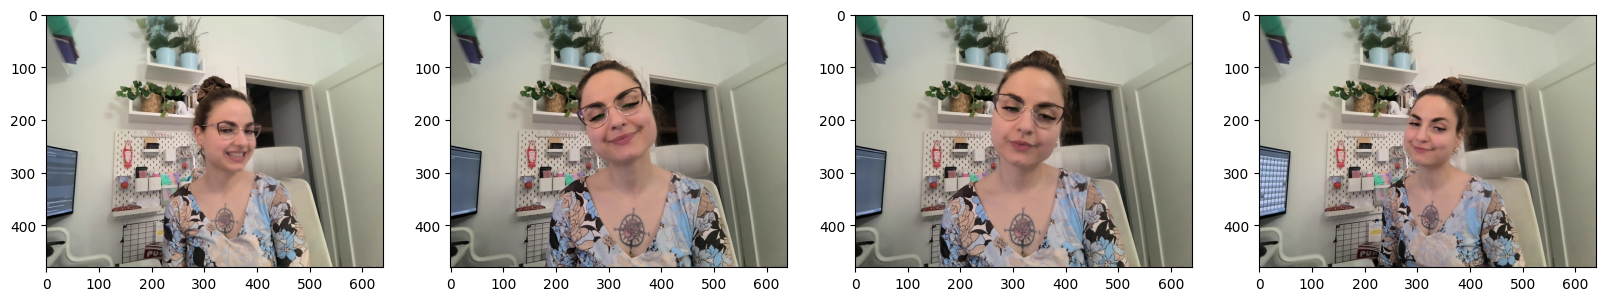

In [20]:
fig, ax = plt.subplots(ncols=4, figsize=(20,20))
for idx, image in enumerate(plot_images):
    ax[idx].imshow(image) 
plt.show()

# 3. Partition Unaugmented Data

### 3.1 MANUALLY SPLT DATA INTO TRAIN TEST AND VAL

In [28]:
341*.7 # 239 to train

238.7

In [27]:
341*.15 # 51 and 51 to test and val

51.15

### 3.2 Move the Matching Labels

In [ ]:
import os
for folder in ['train', 'test', 'val']:
    os.makedirs(os.path.join('data', folder, 'labels'), exist_ok=True)
for folder in ['train', 'test', 'val']:
    image_folder_path = os.path.join('data', folder, 'images')
    
    if not os.path.exists(image_folder_path):
        print(f"Warning: The directory {image_folder_path} does not exist.")
        continue
    for file in os.listdir(image_folder_path):
        filename = file.split('.')[0] + '.json'
        existing_filepath = os.path.join('data', 'labels', filename)
        
        if os.path.exists(existing_filepath):
            new_filepath = os.path.join('data', folder, 'labels', filename)
            os.replace(existing_filepath, new_filepath)
            print(f"Moved: {existing_filepath} to {new_filepath}")

print("Processing completed.")


Processing completed.


# 4. Apply Image Augmentation on Images and Labels using Albumentations

In [ ]:
import cv2
import os

file_path = os.path.join('data', 'train', 'images', 'ff60152f-3597-11ef-8729-04e8b96c0605.jpg')

if os.path.exists(file_path):
    print(f"File exists: {file_path}")
    img = cv2.imread(file_path)
    
    if img is not None:
        print("Image loaded successfully.")
        print(f"Image shape: {img.shape}")
    else:
        print("Failed to load the image. The file might be corrupted or in an unsupported format.")
else:
    print(f"File does not exist: {file_path}")
    
print(f"OpenCV version: {cv2.__version__}")


File exists: data\train\images\ff60152f-3597-11ef-8729-04e8b96c0605.jpg
Image loaded successfully.
Image shape: (480, 640, 3)
OpenCV version: 4.10.0


### 4.1 Setup Albumentations Transform Pipeline

In [34]:
import albumentations as alb

In [41]:
augmentor = alb.Compose([alb.RandomCrop(width=450, height=450), 
                         alb.HorizontalFlip(p=0.5), 
                         alb.RandomBrightnessContrast(p=0.2),
                         alb.RandomGamma(p=0.2), 
                         alb.RGBShift(p=0.2), 
                         alb.VerticalFlip(p=0.5)], 
                       bbox_params=alb.BboxParams(format='albumentations', 
                                                  label_fields=['class_labels']))

### 4.2 Load a Test Image and Annotation with OpenCV and JSON

In [43]:
img

array([[[ 99, 115,  74],
        [ 98, 114,  73],
        [ 96, 112,  71],
        ...,
        [192, 204, 216],
        [192, 204, 216],
        [192, 204, 216]],

       [[101, 117,  76],
        [ 99, 115,  74],
        [ 98, 114,  73],
        ...,
        [193, 205, 217],
        [193, 205, 217],
        [193, 205, 217]],

       [[ 99, 118,  75],
        [ 98, 117,  74],
        [ 98, 117,  74],
        ...,
        [193, 205, 217],
        [194, 206, 218],
        [194, 206, 218]],

       ...,

       [[156, 163, 172],
        [156, 163, 172],
        [152, 159, 168],
        ...,
        [132, 147, 163],
        [133, 148, 164],
        [133, 148, 164]],

       [[156, 164, 171],
        [155, 163, 170],
        [148, 156, 163],
        ...,
        [137, 152, 168],
        [138, 153, 169],
        [138, 153, 169]],

       [[155, 163, 170],
        [155, 163, 170],
        [145, 154, 158],
        ...,
        [140, 155, 171],
        [140, 155, 171],
        [139, 154, 170]]

In [42]:
img = cv2.imread(os.path.join('data','train', 'images','ff60152f-3597-11ef-8729-04e8b96c0605.jpg'))

In [44]:
with open(os.path.join('data', 'train', 'labels', 'ff60152f-3597-11ef-8729-04e8b96c0605.json'), 'r') as f:
    label = json.load(f)

In [46]:
label['shapes'][0]['label']

'smile'

In [47]:
label['shapes'][0]['points']

[[191.55555555555554, 86.22222222222221],
 [344.88888888888886, 332.44444444444446]]

### 4.3 Extract Coordinates and Rescale to Match Image Resolution

In [90]:
coords = [0,0,0,0]
coords[0] = label['shapes'][0]['points'][0][0]
coords[1] = label['shapes'][0]['points'][0][1]
coords[2] = label['shapes'][0]['points'][1][0]
coords[3] = label['shapes'][0]['points'][1][1]

In [91]:
coords

[191.55555555555554, 86.22222222222221, 344.88888888888886, 332.44444444444446]

In [92]:
coords = list(np.divide(coords, [640,480,640,480]))

In [93]:
coords

[0.29930555555555555,
 0.1796296296296296,
 0.5388888888888889,
 0.6925925925925926]

### 4.4 Apply Augmentations and View Results

In [94]:
augmented = augmentor(image=img, bboxes=[coords], class_labels=['smile'])

In [95]:
augmented.keys()

dict_keys(['image', 'bboxes', 'class_labels'])

In [96]:
augmented['image'].shape

(450, 450, 3)

In [97]:
augmented['bboxes'][0][2:]

(0.7987654320987655, 0.6876543209876543)

In [98]:
augmented['bboxes']

[(0.4580246913580248,
  0.1404938271604938,
  0.7987654320987655,
  0.6876543209876543)]

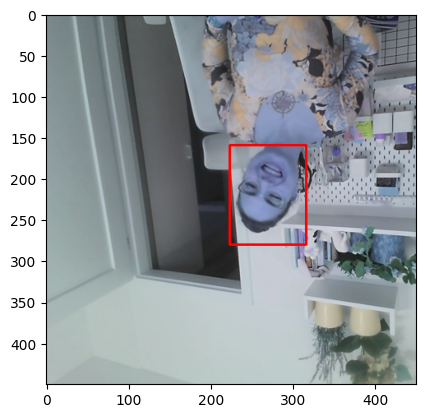

In [200]:
cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450,450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450,450]).astype(int)), 
                    (255,0,0), 2)

plt.imshow(augmented['image'])

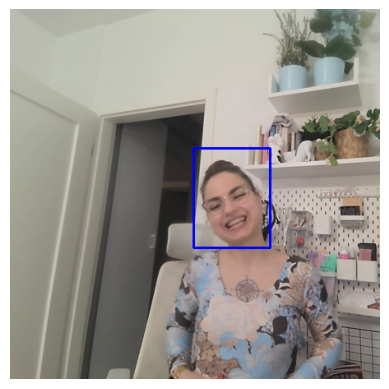

In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt

cv2.rectangle(augmented['image'], 
              tuple(np.multiply(augmented['bboxes'][0][:2], [450, 450]).astype(int)),
              tuple(np.multiply(augmented['bboxes'][0][2:], [450, 450]).astype(int)), 
              (255, 0, 0), 2)

image_rgb = cv2.cvtColor(augmented['image'], cv2.COLOR_BGR2RGB)
image_rgb_flipped = cv2.flip(image_rgb, 0)
plt.imshow(image_rgb_flipped)
plt.axis('off')
plt.show()


# 5. Build and Run Augmentation Pipeline

### 5.1 Run Augmentation Pipeline

In [106]:
for partition in ['train','test','val']: 
    for image in os.listdir(os.path.join('data', partition, 'images')):
        img = cv2.imread(os.path.join('data', partition, 'images', image))

        coords = [0,0,0.00001,0.00001]
        label_path = os.path.join('data', partition, 'labels', f'{image.split(".")[0]}.json')
        if os.path.exists(label_path):
            with open(label_path, 'r') as f:
                label = json.load(f)

            coords[0] = label['shapes'][0]['points'][0][0]
            coords[1] = label['shapes'][0]['points'][0][1]
            coords[2] = label['shapes'][0]['points'][1][0]
            coords[3] = label['shapes'][0]['points'][1][1]
            coords = list(np.divide(coords, [640,480,640,480]))

        try: 
            for x in range(239):
                augmented = augmentor(image=img, bboxes=[coords], class_labels=['smile'])
                cv2.imwrite(os.path.join('aug_data', partition, 'images', f'{image.split(".")[0]}.{x}.jpg'), augmented['image'])

                annotation = {}
                annotation['image'] = image

                if os.path.exists(label_path):
                    if len(augmented['bboxes']) == 0: 
                        annotation['bbox'] = [0,0,0,0]
                        annotation['class'] = 0 
                    else: 
                        annotation['bbox'] = augmented['bboxes'][0]
                        annotation['class'] = 1
                else: 
                    annotation['bbox'] = [0,0,0,0]
                    annotation['class'] = 0 


                with open(os.path.join('aug_data', partition, 'labels', f'{image.split(".")[0]}.{x}.json'), 'w') as f:
                    json.dump(annotation, f)

        except Exception as e:
            print(e)

### 5.2 Load Augmented Images to Tensorflow Dataset

In [107]:
train_images = tf.data.Dataset.list_files('aug_data\\train\\images\\*.jpg', shuffle=False)
train_images = train_images.map(load_image)
train_images = train_images.map(lambda x: tf.image.resize(x, (120,120)))
train_images = train_images.map(lambda x: x/255)

In [108]:
test_images = tf.data.Dataset.list_files('aug_data\\test\\images\\*.jpg', shuffle=False)
test_images = test_images.map(load_image)
test_images = test_images.map(lambda x: tf.image.resize(x, (120,120)))
test_images = test_images.map(lambda x: x/255)

In [109]:
val_images = tf.data.Dataset.list_files('aug_data\\val\\images\\*.jpg', shuffle=False)
val_images = val_images.map(load_image)
val_images = val_images.map(lambda x: tf.image.resize(x, (120,120)))
val_images = val_images.map(lambda x: x/255)

In [110]:
train_images.as_numpy_iterator().next()

array([[[0.59522057, 0.54901963, 0.47996324],
        [0.59068626, 0.547549  , 0.4759804 ],
        [0.5903799 , 0.54724264, 0.46390933],
        ...,
        [0.5167279 , 0.5000613 , 0.53045344],
        [0.42224264, 0.4173407 , 0.44430146],
        [0.57034314, 0.5776961 , 0.6047794 ]],

       [[0.59068626, 0.547549  , 0.47696078],
        [0.5842525 , 0.5425858 , 0.47150734],
        [0.5876838 , 0.54454654, 0.46709558],
        ...,
        [0.6723039 , 0.6958946 , 0.74197304],
        [0.45827207, 0.44816175, 0.4838848 ],
        [0.41256127, 0.39938724, 0.42224264]],

       [[0.5890319 , 0.5503064 , 0.47040442],
        [0.5833333 , 0.55196077, 0.47745097],
        [0.5735294 , 0.5421569 , 0.46764705],
        ...,
        [0.35802695, 0.43192402, 0.4971814 ],
        [0.5488971 , 0.611826  , 0.6877451 ],
        [0.5197304 , 0.5574755 , 0.6206495 ]],

       ...,

       [[0.81960785, 0.7946078 , 0.7127451 ],
        [0.8161152 , 0.7886642 , 0.7141544 ],
        [0.8122549 , 0

# 6. Prepare Labels

### 6.1 Build Label Loading Function

In [111]:
def load_labels(label_path):
    with open(label_path.numpy(), 'r', encoding = "utf-8") as f:
        label = json.load(f)
        
    return [label['class']], label['bbox']

### 6.2 Load Labels to Tensorflow Dataset

In [112]:
train_labels = tf.data.Dataset.list_files('aug_data\\train\\labels\\*.json', shuffle=False)
train_labels = train_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [113]:
test_labels = tf.data.Dataset.list_files('aug_data\\test\\labels\\*.json', shuffle=False)
test_labels = test_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [114]:
val_labels = tf.data.Dataset.list_files('aug_data\\val\\labels\\*.json', shuffle=False)
val_labels = val_labels.map(lambda x: tf.py_function(load_labels, [x], [tf.uint8, tf.float16]))

In [115]:
train_labels.as_numpy_iterator().next()

(array([1], dtype=uint8),
 array([0.523 , 0.257 , 0.9087, 0.8735], dtype=float16))

# 7. Combine Label and Image Samples

### 7.1 Check Partition Lengths

In [116]:
len(train_images), len(train_labels), len(test_images), len(test_labels), len(val_images), len(val_labels)

(57121, 57121, 12189, 12189, 12189, 12189)

### 7.2 Create Final Datasets (Images/Labels)

In [158]:
train = tf.data.Dataset.zip((train_images, train_labels))
train = train.shuffle(5000)
train = train.batch(8)
train = train.prefetch(4)

In [159]:
test = tf.data.Dataset.zip((test_images, test_labels))
test = test.shuffle(1300)
test = test.batch(8)
test = test.prefetch(4)

In [160]:
val = tf.data.Dataset.zip((val_images, val_labels))
val = val.shuffle(1000)
val = val.batch(8)
val = val.prefetch(4)

In [161]:
train.as_numpy_iterator().next()[1]

(array([[1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.3318, 0.367 , 0.6123, 0.776 ],
        [0.2527, 0.2764, 0.5776, 0.618 ],
        [0.2537, 0.342 , 0.5786, 0.6836],
        [0.4211, 0.3313, 0.7896, 0.848 ],
        [0.3596, 0.2764, 0.7437, 0.7314],
        [0.2358, 0.1704, 0.549 , 0.6978],
        [0.2512, 0.3333, 0.559 , 0.6553],
        [0.5454, 0.316 , 0.791 , 0.7407]], dtype=float16))

### 7.3 View Images and Annotations

In [282]:
data_samples = train.as_numpy_iterator()

In [283]:
res = data_samples.next()

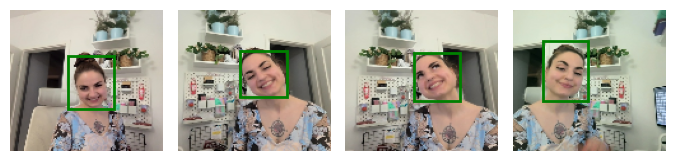

In [449]:
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.patches import Rectangle

def process_and_display_images(data_samples, num_samples=4, box_color='green', box_linewidth=2):
    res = data_samples.next()

    img_height, img_width = res[0][0].shape[:2]
    fig, axes = plt.subplots(ncols=num_samples, figsize=(num_samples * (img_width / 70), img_height / 70))

    for idx in range(num_samples):
        image = np.clip(res[0][idx].copy(), 0, 1)
        
        coords = res[1][1][idx]
        
        top_left = np.multiply(coords[:2], [img_width, img_height])
        width_height = np.multiply(coords[2:] - coords[:2], [img_width, img_height])
        
        ax = axes[idx]
        ax.imshow(image, aspect='auto')
        ax.axis('off')
        rect = Rectangle(top_left, width_height[0], width_height[1],
                         linewidth=box_linewidth, edgecolor=box_color, facecolor='none')
        ax.add_patch(rect)
    

    plt.tight_layout()
    plt.show()


data_samples = train.as_numpy_iterator()
process_and_display_images(data_samples)


# 8. Build Deep Learning using the Functional API

### 8.1 Import Layers and Base Network

In [203]:
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Conv2D, Dense, GlobalMaxPooling2D
from tensorflow.keras.applications import VGG16

### 8.2 Download VGG16

In [204]:
vgg = VGG16(include_top=False)

58889256/58889256 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step


In [205]:
vgg.summary()

Model: "vgg16"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv1 (Conv2D)           │ (None, None, None, 64) │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_conv2 (Conv2D)           │ (None, None, None, 64) │        36,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block1_pool (MaxPooling2D)      │ (None, None, None, 64) │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv1 (Conv2D)           │ (None, None, None,     │        73,856 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_conv2 (Conv2D)           │ (None, None, None,     │       147,584 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block2_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 128)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv1 (Conv2D)           │ (None, None, None,     │       295,168 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv2 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_conv3 (Conv2D)           │ (None, None, None,     │       590,080 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block3_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 256)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv1 (Conv2D)           │ (None, None, None,     │     1,180,160 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block4_pool (MaxPooling2D)      │ (None, None, None,     │             0 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv1 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv2 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ block5_conv3 (Conv2D)           │ (None, None, None,     │     2,359,808 │
│                                 │ 512)                   │             

 Total params: 14,714,688 (56.13 MB)

 Trainable params: 14,714,688 (56.13 MB)

 Non-trainable params: 0 (0.00 B)

### 8.3 Build instance of Network

In [ ]:
from keras.models import Model
from keras.layers import Input, GlobalMaxPooling2D, Dense
from keras.applications import VGG16

def build_model(): 
    input_layer = Input(shape=(120, 120, 3))
    
    vgg = VGG16(include_top=False)(input_layer)
    f1 = GlobalMaxPooling2D()(vgg)
    class1 = Dense(2048, activation='relu')(f1)
    class2 = Dense(1, activation='sigmoid')(class1)
    f2 = GlobalMaxPooling2D()(vgg)
    regress1 = Dense(2048, activation='relu')(f2)
    regress2 = Dense(4, activation='sigmoid')(regress1)
    
    smiletracker = Model(inputs=input_layer, outputs=[class2, regress2])
    return smiletracker


In [452]:
train.as_numpy_iterator().next()[1]

(array([[0],
        [0],
        [0],
        [1],
        [1],
        [1],
        [1],
        [1]], dtype=uint8),
 array([[0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.    , 0.    , 0.    , 0.    ],
        [0.3547, 0.2238, 0.6953, 0.662 ],
        [0.425 , 0.0978, 0.811 , 0.714 ],
        [0.576 , 0.2062, 0.9604, 0.6616],
        [0.4424, 0.3032, 0.7485, 0.644 ],
        [0.3535, 0.3076, 0.6597, 0.6484]], dtype=float16))

### 8.4 Test out Neural Network

In [453]:
smiletracker = build_model()

In [454]:
smiletracker.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_3       │ (None, 120, 120,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ vgg16 (Functional)  │ (None, 3, 3, 512) │ 14,714,688 │ input_layer_3[0]… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ global_max_pooling… │ (None, 512)       │          0 │ vgg16[0][0]       │
│ (GlobalMaxPooling2… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_4 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_6 (Dense)     │ (None, 2048)      │  1,050,624 │ global_max_pooli… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_5 (Dense)     │ (None, 1)         │      2,049 │ dense_4[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_7 (Dense)     │ (None, 4)         │      8,196 │ dense_6[0][0]     │
└─────────────────────┴───────────────────┴────────────┴───────────────────┘

 Total params: 16,826,181 (64.19 MB)

 Trainable params: 16,826,181 (64.19 MB)

 Non-trainable params: 0 (0.00 B)

In [462]:
X, y = train.as_numpy_iterator().next()

In [464]:
X.shape

(8, 120, 120, 3)

In [465]:
classes, coords = smiletracker.predict(X)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 237ms/step


In [466]:
classes, coords

(array([[0.48619506],
        [0.5779004 ],
        [0.52482086],
        [0.5141169 ],
        [0.4723795 ],
        [0.55068177],
        [0.5461291 ],
        [0.50579727]], dtype=float32),
 array([[0.40622982, 0.65360963, 0.4566031 , 0.50086474],
        [0.27064198, 0.6323873 , 0.4936985 , 0.47144935],
        [0.37723917, 0.6836893 , 0.43466547, 0.5076731 ],
        [0.41025862, 0.7242887 , 0.44942042, 0.52342975],
        [0.3202445 , 0.6803421 , 0.4799607 , 0.50697994],
        [0.33034432, 0.67152977, 0.50144076, 0.5323032 ],
        [0.28395948, 0.60323   , 0.4671435 , 0.45713696],
        [0.36881855, 0.67386603, 0.49727678, 0.52431804]], dtype=float32))

# 9. Define Losses and Optimizers

### 9.1 Define Optimizer and LR

In [517]:
len(train)

7141

In [518]:
batches_per_epoch = len(train)
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=0.01,
    decay_steps=batches_per_epoch,
    decay_rate=(1.0-0.75),
    staircase=True
)
opt = tf.keras.optimizers.SGD(learning_rate=lr_schedule, momentum=0.9)

Epoch 1: Learning Rate = 0.010000
Epoch 2: Learning Rate = 0.002500
Epoch 3: Learning Rate = 0.000625
Epoch 4: Learning Rate = 0.000156
Epoch 5: Learning Rate = 0.000039
Epoch 6: Learning Rate = 0.000010
Epoch 7: Learning Rate = 0.000002
Epoch 8: Learning Rate = 0.000001
Epoch 9: Learning Rate = 0.000000
Epoch 10: Learning Rate = 0.000000
Epoch 11: Learning Rate = 0.000000
Epoch 12: Learning Rate = 0.000000
Epoch 13: Learning Rate = 0.000000
Epoch 14: Learning Rate = 0.000000
Epoch 15: Learning Rate = 0.000000
Epoch 16: Learning Rate = 0.000000
Epoch 17: Learning Rate = 0.000000
Epoch 18: Learning Rate = 0.000000
Epoch 19: Learning Rate = 0.000000
Epoch 20: Learning Rate = 0.000000
Epoch 21: Learning Rate = 0.000000
Epoch 22: Learning Rate = 0.000000
Epoch 23: Learning Rate = 0.000000
Epoch 24: Learning Rate = 0.000000
Epoch 25: Learning Rate = 0.000000
Epoch 26: Learning Rate = 0.000000
Epoch 27: Learning Rate = 0.000000
Epoch 28: Learning Rate = 0.000000
Epoch 29: Learning Rate = 0.0

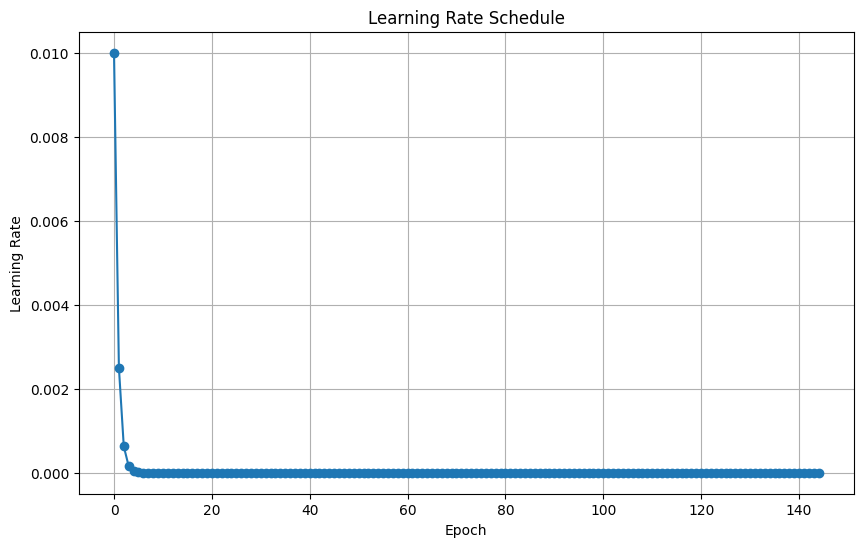

In [ ]:
def get_learning_rate(epoch):
    lr = lr_schedule(epoch * batches_per_epoch).numpy()
    print(f"Epoch {epoch + 1}: Learning Rate = {lr:.6f}")
    return lr
learning_rates = [get_learning_rate(epoch) for epoch in range(num_epochs)]
plt.figure(figsize=(10, 6))
plt.plot(range(num_epochs), learning_rates, marker='o')
plt.title('Learning Rate Schedule')
plt.xlabel('Epoch')
plt.ylabel('Learning Rate')
plt.grid(True)
plt.show()

### 9.2 Create Localization Loss and Classification Loss

In [520]:
def localization_loss(y_true, y_pred):
    delta_coord = tf.reduce_sum(tf.square(y_true[:, :2] - y_pred[:, :2]))
    h_true = y_true[:, 2] - y_true[:, 0]
    w_true = y_true[:, 3] - y_true[:, 1]
    h_pred = y_pred[:, 2] - y_pred[:, 0]
    w_pred = y_pred[:, 3] - y_pred[:, 1]
    delta_size = tf.reduce_sum(tf.square(h_true - h_pred) + tf.square(w_true - w_pred))
    return delta_coord + delta_size

In [521]:
classloss = tf.keras.losses.BinaryCrossentropy()
regressloss = localization_loss

### 9.3 Test out Loss Metrics

In [526]:
localization_loss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.550701>

In [523]:
classloss(y[0], classes)

<tf.Tensor: shape=(), dtype=float32, numpy=0.66399467>

In [524]:
regressloss(y[1], coords)

<tf.Tensor: shape=(), dtype=float32, numpy=4.550701>

# 10. Train Neural Network

### 10.1 Create Custom Model Class

In [564]:
import tensorflow as tf
from tensorflow.keras.models import Model

class SmileTracker(Model):
    def __init__(self, eyetracker, **kwargs): 
        super(SmileTracker, self).__init__(**kwargs)
        self.model = eyetracker

    def compile(self, opt, classloss, localizationloss, **kwargs):
        super(SmileTracker, self).compile(**kwargs)
        self.closs = classloss
        self.lloss = localizationloss
        self.opt = opt
    
    def train_step(self, batch, **kwargs): 
        X, y = batch
        
        with tf.GradientTape() as tape: 
            classes, coords = self.model(X, training=True)
            
            batch_classloss = self.closs(y[0], classes)
            batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
            
            total_loss = batch_localizationloss + 0.5 * batch_classloss
            
            grad = tape.gradient(total_loss, self.model.trainable_variables)
            self.opt.apply_gradients(zip(grad, self.model.trainable_variables))
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
    
    def test_step(self, batch, **kwargs): 
        X, y = batch
        
        classes, coords = self.model(X, training=False)
        
        batch_classloss = self.closs(y[0], classes)
        batch_localizationloss = self.lloss(tf.cast(y[1], tf.float32), coords)
        total_loss = batch_localizationloss + 0.5 * batch_classloss
        
        return {"total_loss": total_loss, "class_loss": batch_classloss, "regress_loss": batch_localizationloss}
        
    def call(self, X, **kwargs): 
        return self.model(X, **kwargs)


In [565]:
model = SmileTracker(smiletracker)

In [566]:
model.compile(opt, classloss, regressloss)

In [ ]:
eyetracker_model = build_model()
smile_tracker = SmileTracker(eyetracker_model)
smile_tracker.compile(
    opt=tf.keras.optimizers.Adam(),
    classloss=tf.keras.losses.BinaryCrossentropy(),
    localizationloss=tf.keras.losses.MeanSquaredError()
)

### 10.2 Train

In [755]:
logdir='logs'

In [756]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=logdir)

In [ ]:
from tensorflow.keras.optimizers import SGD
facetracker.compile(
    optimizer=SGD(learning_rate=0.0),   
    loss='binary_crossentropy',        
    metrics=['accuracy']
)
hist = facetracker.fit(
    train_dataset, 
    epochs=145, 
    validation_data=val_dataset, 
    callbacks=[tensorboard_callback]
)

In [574]:
hist.history

{'class_loss': [21.894779205322266,
  4.915833950042725,
  2.8480982780456543,
  0.030694331973791122,
  0.01368158683180809,
  0.011114327237010002,
  0.01878008060157299,
  0.01471512671560049,
  0.01043708249926567,
  0.02173030562698841,
  0.009956625290215015,
  0.010677924379706383,
  0.011927385814487934,
  0.009269321337342262,
  0.009388071484863758,
  0.009401170536875725,
  0.008505716919898987,
  0.008289588615298271,
  0.008114824071526527,
  0.007696549873799086,
  0.007428329437971115,
  0.007218791171908379,
  0.006954523269087076,
  0.006717028096318245,
  0.006514093838632107,
  0.006309209857136011,
  0.006110413931310177,
  0.00592764001339674,
  0.0057532512582838535,
  0.005584480706602335,
  0.005423891823738813,
  0.005271067842841148,
  0.00512425834313035,
  0.0049832905642688274,
  0.00484825111925602,
  0.004718568176031113,
  0.004593859426677227,
  0.0044738552533090115,
  0.004358386155217886,
  0.004247186705470085,
  0.004139992408454418,
  0.0040366179

### 10.3 Plot Performance

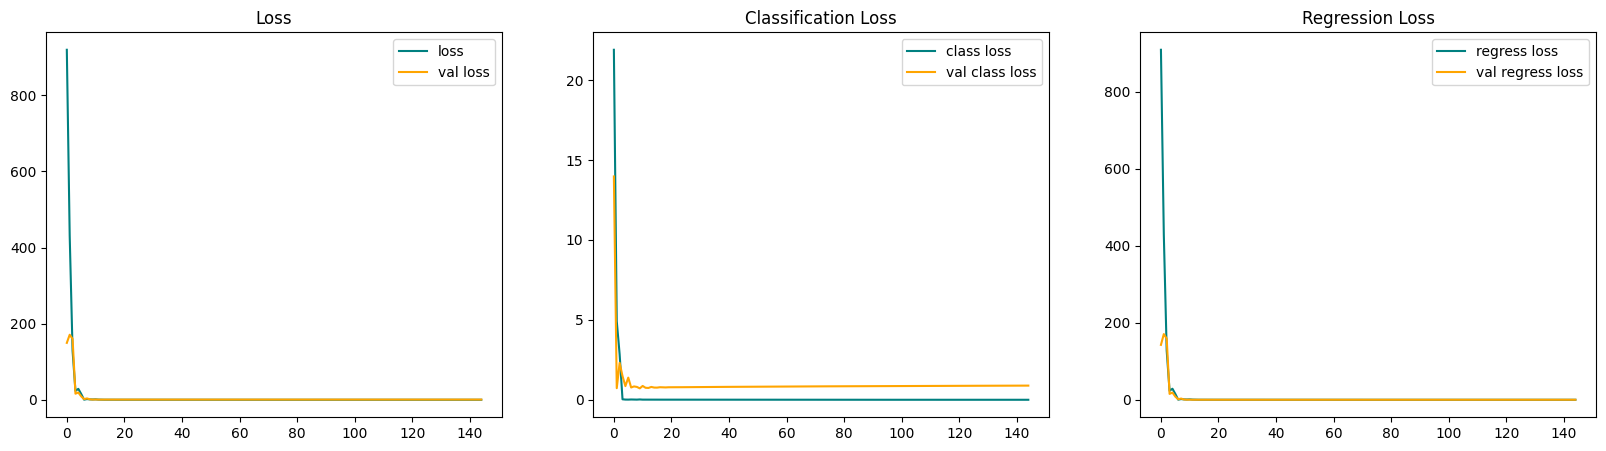

In [759]:
fig, ax = plt.subplots(ncols=3, figsize=(20,5))

ax[0].plot(hist.history['total_loss'], color='teal', label='loss')
ax[0].plot(hist.history['val_total_loss'], color='orange', label='val loss')
ax[0].title.set_text('Loss')
ax[0].legend()

ax[1].plot(hist.history['class_loss'], color='teal', label='class loss')
ax[1].plot(hist.history['val_class_loss'], color='orange', label='val class loss')
ax[1].title.set_text('Classification Loss')
ax[1].legend()

ax[2].plot(hist.history['regress_loss'], color='teal', label='regress loss')
ax[2].plot(hist.history['val_regress_loss'], color='orange', label='val regress loss')
ax[2].title.set_text('Regression Loss')
ax[2].legend()

plt.show()

# 11. Make Predictions

### 11.1 Make Predictions on Test Set

In [750]:
test_data = test.as_numpy_iterator()

In [751]:
test_sample = test_data.next()

In [752]:
yhat = facetracker.predict(test_sample[0])

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 202ms/step


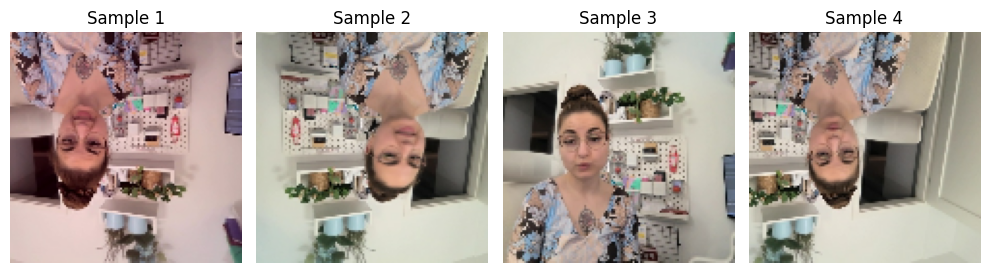

In [753]:
fig, ax = plt.subplots(ncols=4, figsize=(10, 10))
# Removed suptitle to avoid extra white space
# fig.suptitle('Face Tracking Predictions')

for idx in range(4):
    if idx >= len(test_sample[0]):
        break  # Ensure there are enough samples to plot

    sample_image = test_sample[0][idx]
    sample_coords = yhat[1][idx]

    if yhat[0][idx] > 0.9:
        img_height, img_width = sample_image.shape[:2]
        start_point = tuple(np.multiply(sample_coords[:2], [img_width, img_height]).astype(int))
        end_point = tuple(np.multiply(sample_coords[2:], [img_width, img_height]).astype(int))
        
        cv2.rectangle(sample_image, start_point, end_point, (255, 0, 0), 2)
    
    ax[idx].imshow(sample_image)
    ax[idx].set_title(f'Sample {idx+1}')
    ax[idx].axis('off')  # Hide axes for better visualization

# Adjust layout to reduce white space
plt.tight_layout()
plt.show()

### 11.2 Save the Model

In [715]:
from tensorflow.keras.models import load_model

In [ ]:
facetracker.save('smiletracker.keras')

In [725]:
facetracker = load_model('smiletracker.keras')

### 11.3 Real Time Detection

In [ ]:
cap = cv2.VideoCapture(0)
while cap.isOpened():
    _ , frame = cap.read()
    frame = frame[50:500, 50:500,:]
    
    rgb = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
    resized = tf.image.resize(rgb, (120,120))
    
    yhat = smiletracker.predict(np.expand_dims(resized/255,0))
    sample_coords = yhat[1][0]
    
    if yhat[0] > 0.5: 
        cv2.rectangle(frame, 
                      tuple(np.multiply(sample_coords[:2], [450,450]).astype(int)),
                      tuple(np.multiply(sample_coords[2:], [450,450]).astype(int)), 
                            (255,0,0), 2)
        cv2.rectangle(frame, 
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int), 
                                    [0,-30])),
                      tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                    [80,0])), 
                            (255,0,0), -1)
        
        cv2.putText(frame, 'face', tuple(np.add(np.multiply(sample_coords[:2], [450,450]).astype(int),
                                               [0,-5])),
                    cv2.FONT_HERSHEY_SIMPLEX, 1, (255,255,255), 2, cv2.LINE_AA)
    
    cv2.imshow('EyeTrack', frame)
    
    if cv2.waitKey(1) & 0xFF == ord('q'):
        break
cap.release()
cv2.destroyAllWindows()